In [1]:
x = "D:\projects\segmentation of aerial imagery\data\org_data\image"
y = "D:\projects\segmentation of aerial imagery\data\org_data\mask"

In [2]:
from models.dataloader import Aerial
datadir = r'D:\projects\segmentation of aerial imagery\data\org_data'
dataset = Aerial(datadir)
len(dataset)

1305

In [3]:
import os
import numpy as np
import cv2
import torch
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader
import torch.nn as nn


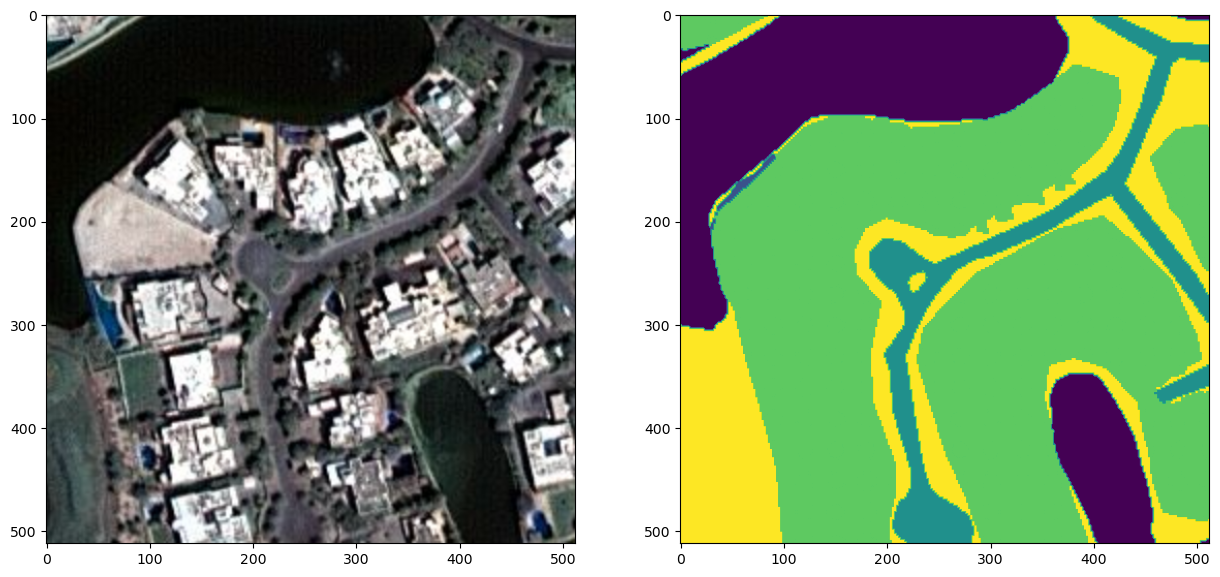

In [4]:
d = dataset[100] ## __getitem__ is called
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(d[0].numpy(),0,-1))
plt.subplot(1,2,2)
plt.imshow(d[1])

In [5]:
test_num = int(0.25 * len(dataset))
print(f'test data : {test_num}')
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(101))

BACH_SIZE = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BACH_SIZE, shuffle=True, num_workers=0)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BACH_SIZE, shuffle=False, num_workers=0)

test data : 326


In [6]:
torch.cuda.is_available()

True

In [7]:

def get_default_device():
    # pick the gpu if available
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    #move tensors to choosen device
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)


class DeviceDataLoader():
    # move the batches of the data to our selected device
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

device = get_default_device()

train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)


In [8]:
from models.loss import FocalLoss
criterion = FocalLoss(gamma=3/4).to(device)

In [9]:
def acc(label, predicted):
    seg_acc = (label.cpu() == torch.argmax(predicted, axis=1).cpu()).sum() / torch.numel(y.cpu())
    return seg_acc

In [10]:
from models.model import UNet
min_loss = torch.tensor(float('inf'))

model = to_device(UNet(n_channels=3, n_classes=6, bilinear=True),device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [11]:
os.makedirs('./saved_models', exist_ok=True)

N_EPOCHS = 50
N_DATA = len(train_dataset)
N_TEST = len(test_dataset)

plot_losses = []
scheduler_counter = 0

In [12]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

17267718

In [ ]:
for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y) in enumerate(train_dataloader):
      pred_mask = model(x)  #[4,6,512,512]
      loss = criterion(pred_mask, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y) in enumerate(test_dataloader):
      with torch.no_grad():    
          pred_mask = model(x)  
      val_loss = criterion(pred_mask, y)
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())
      
      
  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch, 
                                                                                                 np.mean(loss_list), 
                                                                                                 np.mean(acc_list), 
                                                                                                 np.mean(val_loss_list),
                                                                                                 np.mean(val_acc_list)))
  
   
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])

  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
    torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
  
  if scheduler_counter > 5:
    lr_scheduler.step()
    print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
    scheduler_counter = 0

[Epoch 0/50] [Batch 244/245] [Loss: 0.771323 (0.706476)] epoch 0 - loss : 0.70648 - acc : 0.70 - val loss : 0.55756 - val acc : 0.77
[Epoch 1/50] [Batch 244/245] [Loss: 0.434148 (0.603463)] epoch 1 - loss : 0.60346 - acc : 0.73 - val loss : 0.65976 - val acc : 0.69
[Epoch 2/50] [Batch 244/245] [Loss: 0.417231 (0.574598)] epoch 2 - loss : 0.57460 - acc : 0.74 - val loss : 0.55939 - val acc : 0.76
[Epoch 3/50] [Batch 62/245] [Loss: 0.502211 (0.559915)]